<a href="https://colab.research.google.com/github/sekhrianchal6/Arima/blob/main/Ravindra_rf_Arima_MT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/sekhrianchal6/Arima/main/Maternal%20Health%20Risk%20Data%20Set.csv')

In [3]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [4]:
df['RiskLevel'].replace({"high risk": "3", "mid risk": "2", "low risk" : "1"}, inplace=True)
df['RiskLevel'] = df['RiskLevel'].astype(float)
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,3.0
1,35,140,90,13.0,98.0,70,3.0
2,29,90,70,8.0,100.0,80,3.0
3,30,140,85,7.0,98.0,70,3.0
4,35,120,60,6.1,98.0,76,1.0


In [5]:
#df with duplicates
dfwd = df.copy()

In [6]:
#df of only duplicates
dfd = df.loc[df.duplicated(),:]


In [7]:
# df without duplicates
dfwnd = df.drop_duplicates()

In [8]:
print(f"data with duplicates: {len(dfwd)}\ndata without duplicates: {len(dfwnd)}\ndata of only duplicates entries: {len(dfd)}")

data with duplicates: 1014
data without duplicates: 452
data of only duplicates entries: 562


# Feature Selection

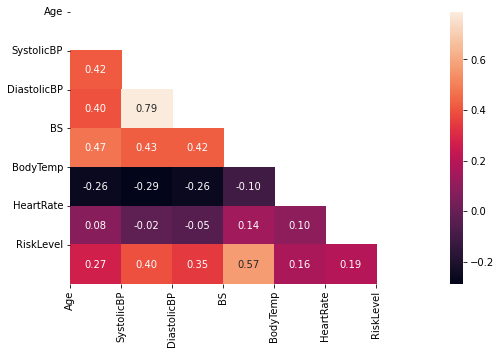

In [9]:
corr = df.corr()
#mask the repeated  values
mask = np.zeros_like(corr,dtype=bool);
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 5));
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, fmt=".2f" , mask=mask,);
    #Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns);
    #show plot
plt.show()

[0.01991597 0.04713037 0.03289768 0.08192967 0.01644961 0.01424221
 0.7874345 ]


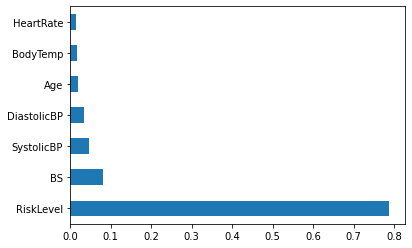

In [10]:
X = df.iloc[:,0:20]  #independent columns
y = df.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Algorithm Selection

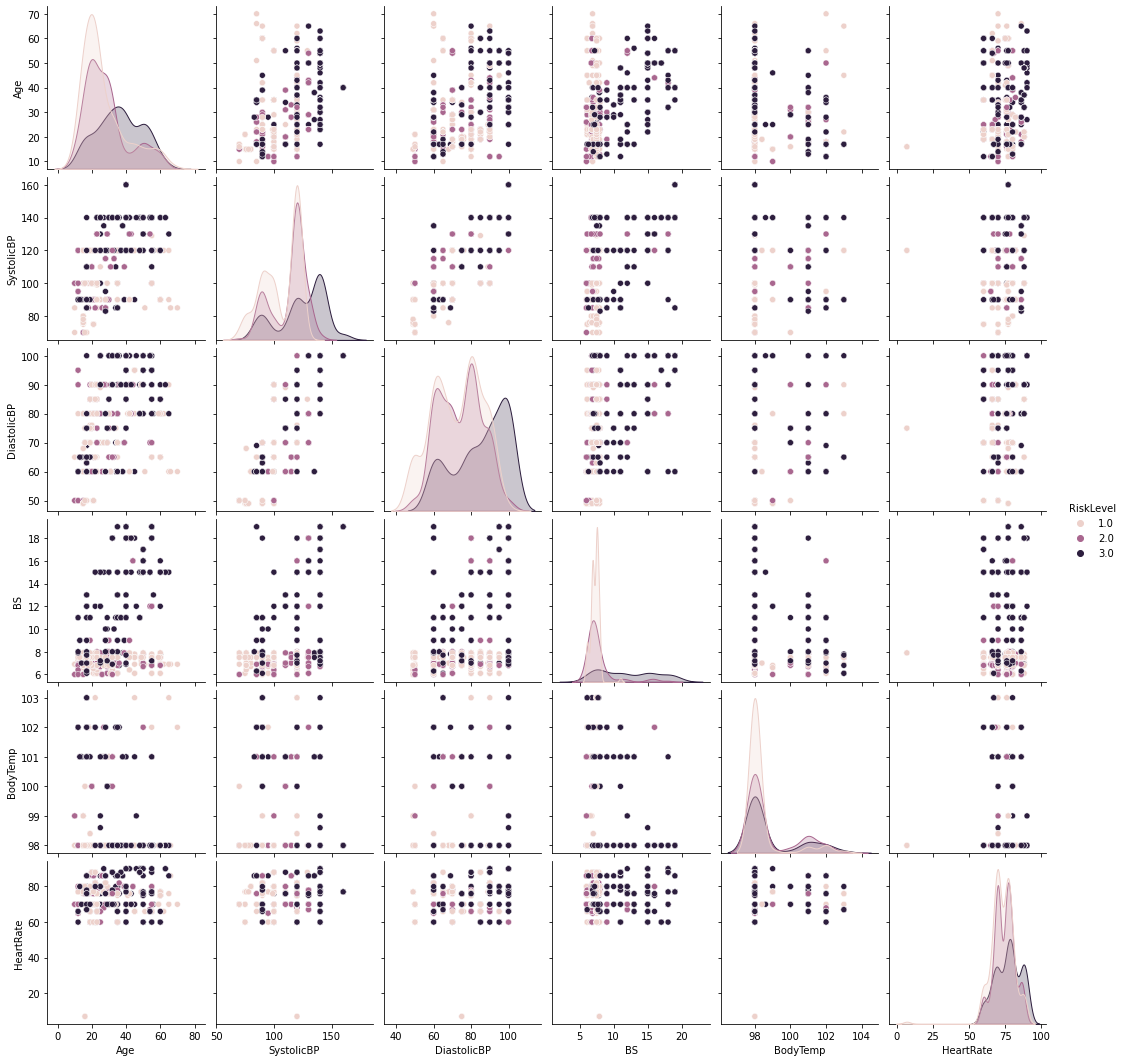

In [11]:
sns.pairplot(df, hue='RiskLevel')

# Model Evaluation and Hyperparameter Tuning: Finding the Best parameter

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_values = df.drop('RiskLevel', axis=1)
y_values = df['RiskLevel']

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_values,y_values,
                                                 test_size=0.25,random_state= 42)


In [15]:
X_train.shape,X_test.shape

((760, 6), (254, 6))

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [17]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [19]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [20]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.2165 degrees.
Accuracy = 83.99%.


In [21]:
base_model.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [22]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.2126 degrees.
Accuracy = 84.38%.
